Evaluate

In [1]:
from gettext import find
from operator import itemgetter
from copy import deepcopy
from itertools import chain


def find_available_space(spaces, box_size, box_vol):
    l, w, h = box_size

    for space in spaces:
        space_vol = space[3] * space[4] * space[5]  # Volumen del espacio

        if space_vol >= box_vol and space[3] >= l and space[4] >= w and space[5] >= h:
            return space

    return None


def evaluate(population, container_dimension, types):
    container_vol = container_dimension[0] * \
        container_dimension[1] * container_dimension[2]
    for key, individual in enumerate(population):
        types_num = individual['types_num']
        counts = individual['counts']
        rotations = individual['rotations']

        dblf = [
            [[0, 0, 0] + container_dimension + [types_num[0]]],  # side
            [],                                                # top
            []                                                 # front
        ]

        occupied_vol = 0
        number_boxes = 0
        value = 0
        result = []
        for i in range(len(types_num)):
            box_counts = counts[i]
            n_type = types_num[i]
            r = rotations[i]
            one_type = types[n_type]
            if one_type['max_count'] < box_counts:
                print("El número de cajas supera el límite %d > %d" % (box_counts, one_type['max_count']))
             
            box_value = one_type['value_individual']

            # Rotación de la caja de dos tipos
            if r == 0:
                l, w, h = one_type['box_size']
            else:
                w, l, h = one_type['box_size']

            box_vol = w * l * h
            number_boxes_type = 0
            box_number = 0
            while box_number < box_counts:
                box_number += 1
                curr = find_available_space(
                    chain.from_iterable(dblf), [l, w, h], box_vol)
                if curr:
                    result.append(curr[0:3] + [l, w, h, n_type])

                    occupied_vol += box_vol
                    number_boxes += 1
                    number_boxes_type += 1
                    value += box_value

                    # Dividir el espacio restante
                    new_spaces = [
                        [curr[0], curr[1] + w, curr[2],
                            l, curr[4] - w, h, n_type] if curr[4] - w > 0 else None,  # lado
                        [curr[0], curr[1], curr[2] + h,
                            l, curr[4], curr[5] - h, n_type] if curr[5] - h > 0 else None,  # arriba
                        [curr[0] + l, curr[1], curr[2],
                            curr[3] - l, curr[4], curr[5], n_type] if curr[3] - l > 0 else None  # frente
                    ]

                    for _i in range(3):
                        # Eliminar el espacio actual
                        if curr in dblf[_i]:
                            dblf[_i].remove(curr)

                        # Añadir los nuevos espacios
                        if new_spaces[_i]:
                            dblf[_i].append(new_spaces[_i])

                # Si se ha llegado al límite de cajas, intentar aumentar el límite de cajas si queda espacio al costado o arriba
                if box_number == box_counts:
                    curr = find_available_space(
                        chain.from_iterable(dblf[1:2]), [l, w, h], box_vol)
                    if curr and box_counts < one_type['max_count']:
                        box_counts += 1
            # Si el número de cajas ahora ha cambiado, actualizar en la población
            if number_boxes_type < box_counts:
                population[key]['counts'][i] = number_boxes_type
            elif box_counts != counts[i]:
                population[key]['counts'][i] = box_counts

            # Para evitar colocar cajas en espacios inaccesibles, eliminar los espacio laterales y superiores
            #dblf[0] = []
            dblf[1] = []

        fitness_value = [round((occupied_vol / container_vol), 2),
                         number_boxes,
                         value]
        population[key]['fitness'] = deepcopy(fitness_value)
        population[key]['result'] = result
    return population

# _=evaluate([the_best(population)], container_dimension, types)
# draw_anim_types(the_best(population))

Draw

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
import seaborn as sns

plt.style.use('fast')
rcParams['figure.figsize'] = 8, 5

pallete = sns.color_palette("Paired", 10) + sns.color_palette("Accent", 10)


def cuboid_data(o, size=(1, 1, 1)):
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],
         [o[1], o[1], o[1], o[1], o[1]],
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]
    z = [[o[2], o[2], o[2], o[2], o[2]],
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]
    return np.array(x), np.array(y), np.array(z)


def plotcuboid(pos=(0, 0, 0), size=(1, 1, 1), ax=None, **kwargs):
    # Plotting a cube element at position pos
    if ax is not None:
        X, Y, Z = cuboid_data(pos, size)
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, **kwargs)


def draw(pieces, title="", container_dimension=None):
    positions = []
    sizes = []
    colors = []
    #sorted_size = []
    #Ordenar las piezas para que se impriman bien
    #pieces = sorted(pieces, key=lambda x: (x[1], x[0], x[2]))
    for each in pieces:
        positions.append(each[0:3])
        sizes.append(each[3:6])
        #sorted_size.append(set(each[3:6]))
        colors.append(pallete[each[6]])
    
    #plt.interactive(True)
    fig = plt.figure()#dpi=150)
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection = '3d')

    for p, s, c in zip(positions, sizes, colors):
        plotcuboid(pos=p, size=s, ax=ax, color=c, alpha=0.8, antialiased=True, edgecolor=c)
    if title:
        plt.title(title)
    if container_dimension != None:
        ax.set_xlim([0, container_dimension[0]])
        ax.set_ylim([0, container_dimension[1]])
        ax.set_zlim([0, container_dimension[2]])
        #draw container boundaries
        x, y, z = cuboid_data([0, 0, 0], container_dimension)
        ax.plot_surface(x, y, z, color='b', alpha=0.01, rstride=1, cstride=1, edgecolor='black')
    
    plt.axis('off')
    ax.set_aspect('equal')
    plt.show()


Generar población

In [3]:
import random
from copy import deepcopy


def generate_pop(types, count=100, seed=0):
    #random.seed(seed)
    population = []
    for i in range(0, count):
        type_nums = list(range(len(types)))
        random.shuffle(type_nums)
        gen = {
            "counts": [random.randint(0, types[t]['boxes_count']) for t in type_nums],
            "types_num": type_nums,
            "rotations": [random.randint(0, 1) for r in range(len(types))]
        }
        population.append(gen)
    return population

Crear Dataset

In [4]:
import json
import random
import math

MIN_BOXES = 20
MAX_BOXES = 100
MIN_TYPES = 14
MAX_TYPES = 14
MIN_VALUE = 50
MAX_VALUE = 500
MAX_CONTAINER_LEN = 120  # x10
MIN_CONTAINER_LEN = 120
MAX_CONTAINER_WID = 23
MIN_CONTAINER_WID = 23
MAX_CONTAINER_HT = 23
MIN_CONTAINER_HT = 23

container_dim = [[random.randint(MIN_CONTAINER_LEN, MAX_CONTAINER_LEN), random.randint(MIN_CONTAINER_WID, MAX_CONTAINER_WID),
                  random.randint(MIN_CONTAINER_HT, MAX_CONTAINER_HT)] for _ in range(1)]
NUM_BOXES = [
    [random.randint(MIN_BOXES, MAX_BOXES), random.randint(MIN_BOXES, MAX_BOXES), random.randint(MIN_BOXES, MAX_BOXES),
     random.randint(MIN_BOXES, MAX_BOXES), random.randint(MIN_BOXES, MAX_BOXES)] for _ in range(1)]
NUM_TYPES = [
    [random.randint(MIN_TYPES, MAX_TYPES)] for _ in range(1)]


def generate_types(container, num):
    retry = 50 * num
    while num > 1:
        cuboid = random.choice(container)
        while cuboid[3] <= 10 or cuboid[4] <= 10 or cuboid[5] <= 10:
            retry -= 1
            if retry == 0:
                print("Cannot partition into packages. Please try again")
                num = -1
                break
            cuboid = random.choice(container)
        container.remove(cuboid)
        part = random.choice(
            ['length', 'width', 'length', 'height', 'length', 'length'])
        x1 = cuboid[0]
        y1 = cuboid[1]
        z1 = cuboid[2]
        x2 = cuboid[3]
        y2 = cuboid[4]
        z2 = cuboid[5]
        if part == 'length':
            # Split in length
            t = random.randint(5, int(x2 / 2))
            package1 = [x1 + t, y1, z1, x2 - t, y2, z2]
            package2 = [x1, y1, z1, t, y2, z2]
        elif part == 'width':
            # Split in width
            t = random.randint(5, int(y2 / 2))
            package1 = [x1, y1 + t, z1, x2, y2 - t, z2]
            package2 = [x1, y1, z1, x2, t, z2]
        else:
            # Split in height
            t = random.randint(5, int(z2 / 2))
            package1 = [x1, y1, z1 + t, x2, y2, z2 - t]
            package2 = [x1, y1, z1, x2, y2, t]

        container.append(package1)
        container.append(package2)
        num -= 1

    for i in range(len(container)):
        container[i].append(i)  # Asignar un número a cada tipo de caja
    return [{
        'container': c,
        'value_individual': random.randint(MIN_VALUE, MAX_VALUE)
    } for c in container]


MIN_BOX_SIZE = 3
MAX_BOX_SIZE = 5


def generate_boxes(types):
    boxes = []
    total_value = 0
    packages = []
    for n_type, one_type in enumerate(types):
        container = one_type['container']
        x, y, z = container[0:3]
        l, w, h = container[3:6]

        div_l = math.floor(random.uniform(
            l/MAX_BOX_SIZE, l/MIN_BOX_SIZE)) if l > MAX_BOX_SIZE else 1
        div_w = math.floor(random.uniform(
            w/MAX_BOX_SIZE, w/MIN_BOX_SIZE)) if w > MAX_BOX_SIZE else 1
        div_h = math.floor(random.uniform(
            h/MAX_BOX_SIZE, h/MIN_BOX_SIZE)) if h > MAX_BOX_SIZE else 1
        new_l = math.floor(l / div_l) if div_l > 1 else l
        new_w = math.floor(w / div_w) if div_w > 1 else w
        new_h = math.floor(h / div_h) if div_h > 1 else h

        # Actualizar el tipo de caja
        new_box_number = div_l * div_w * div_h  # Número de cajas
        volume_individual = new_l * new_w * new_h  # Volumen individual

        one_type['value_individual'] = volume_individual
        one_type.update({
            'box_size': [new_l, new_w, new_h],  # Tamaño de la caja
            'volume_individual': volume_individual,
            'volume_total': new_box_number * volume_individual,
            'value_total': one_type['value_individual'] * new_box_number,
            'boxes_count': new_box_number,
            # Se permite entre un 30% y 50% más de cajas
            'max_count': round(new_box_number*(1+random.uniform(0.3, 0.5))),
        })

        # Generar las cajas
        new_boxes = [[new_l, new_w, new_h, n_type]] * div_l * div_w * div_h
        # Agregar los packages en vez de uno, los múltiples generados
        for i in range(div_l):
            for j in range(div_w):
                for k in range(div_h):
                    packages.append([x + i * new_l, y + j * new_w,
                                     z + k * new_h, new_l, new_w, new_h, n_type])

        boxes += new_boxes
    return packages, boxes


def generate_dataset():
    dataset = {}
    i = 0

    for cont, counts in zip(container_dim, NUM_TYPES):
        for number in counts:
            gen_types = generate_types([[0, 0, 0] + cont], number)
            packages, boxes = generate_boxes(gen_types)
            total_value = sum([t['value_total'] for t in gen_types])
            # draw([x['container'] for x in types])
            # draw(packages)
            dataset[i] = {'container_dimension': cont,
                          'number': number,
                          'types': gen_types,
                          # 'boxes': boxes,
                          'solution': packages,
                          'total_value': total_value}
            i += 1
    return dataset


#with open('input.json', 'w') as outfile:
#    json.dump(generate_dataset(), outfile)

In [5]:
with open('input.json', 'r') as outfile:
    data = json.load(outfile)
problem_indices = list(data.keys())

NUM_OF_INDIVIDUALS = 100  # 36


p_ind = problem_indices[0]
container_dimension = data[p_ind]['container_dimension']
types = data[p_ind]['types']

population = generate_pop(types, NUM_OF_INDIVIDUALS)
_ = evaluate(population, container_dimension, types)

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
container_dimension

[120, 23, 23]

In [ ]:
types

[{'container': [66, 0, 0, 15, 23, 23, 0],
  'value_individual': 60,
  'box_size': [5, 3, 4],
  'volume_individual': 60,
  'volume_total': 6300,
  'value_total': 6300,
  'boxes_count': 105,
  'max_count': 156},
 {'container': [95, 0, 0, 25, 7, 23, 1],
  'value_individual': 36,
  'box_size': [4, 3, 3],
  'volume_individual': 36,
  'volume_total': 2592,
  'value_total': 2592,
  'boxes_count': 72,
  'max_count': 102},
 {'container': [88, 0, 0, 7, 23, 23, 2],
  'value_individual': 140,
  'box_size': [7, 5, 4],
  'volume_individual': 140,
  'volume_total': 2800,
  'value_total': 2800,
  'boxes_count': 20,
  'max_count': 28},
 {'container': [81, 0, 0, 7, 23, 23, 3],
  'value_individual': 140,
  'box_size': [7, 4, 5],
  'volume_individual': 140,
  'volume_total': 2800,
  'value_total': 2800,
  'boxes_count': 20,
  'max_count': 29},
 {'container': [18, 0, 0, 32, 11, 23, 4],
  'value_individual': 48,
  'box_size': [4, 3, 4],
  'volume_individual': 48,
  'volume_total': 5040,
  'value_total': 504

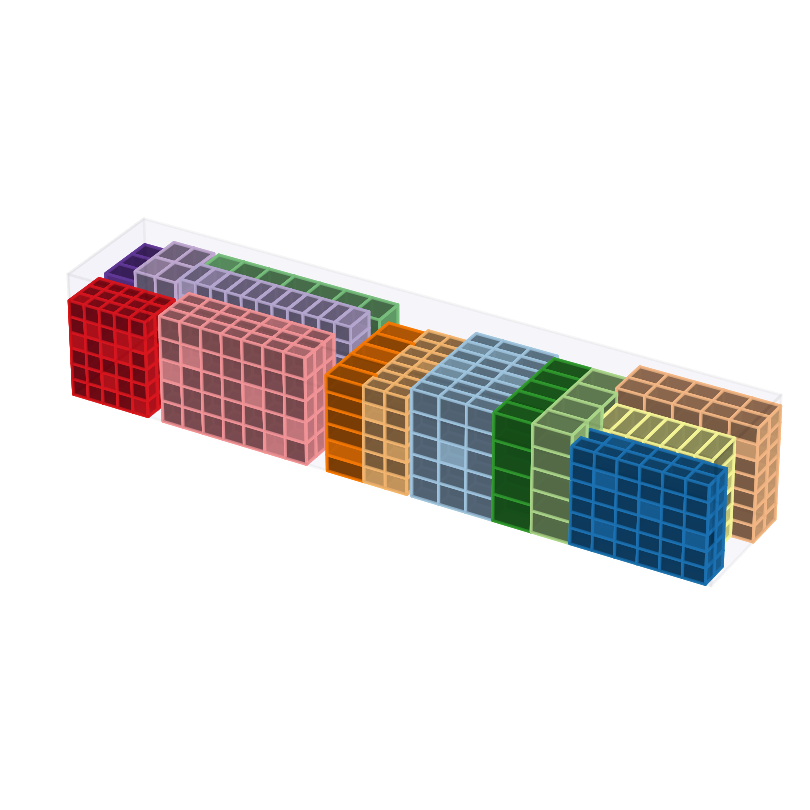

In [ ]:
# Imprimir la solución esperada
draw(data[p_ind]['solution'],
     container_dimension=data[p_ind]['container_dimension'])

In [ ]:
def fit(chromosome):
    return chromosome['fitness'][2]


def the_best(population):
    return max(population, key=fit)


def the_best_fit(population):
    return fit(the_best(population))

def draw_anim_types(solution):
    for t in range(1, len(solution['types_num'])+1):
        types_included = solution['types_num'][:t]
        boxes = list(filter(lambda x: x[6] in types_included, solution['result']))
        draw(boxes, container_dimension=container_dimension)
        clear_output(wait=True)

In [ ]:
# Guardamos el mejor individuo random generado
max_rand = deepcopy(the_best(population))
fit(max_rand)

45693

In [ ]:
# Cruza dos padres usando un solo punto y devuelve un único hijo tomando la primera parte del primer padre y la segunda parte del segundo padre
def crossover_one_point(p_1, p_2, point):
    child = {
        'types_num': p_1['types_num'][:point],
        'counts': p_1['counts'][:point],
        'rotations': p_1['rotations'][:point]
    }
    for i in range(len(p_2['types_num'])):
        t = p_2['types_num'][i]
        if t not in child['types_num']:
            child['types_num'].append(t)
            child['counts'].append(p_2['counts'][i])
            child['rotations'].append(p_2['rotations'][i])
    return child

# Realiza el cruzamiento de dos padres y devuelve dos hijos
def crossover(parent_1, parent_2):
    # Cruzamiento de un punto
    crossover_point = random.randint(1, len(parent_1['types_num']) - 1)
    child_1 = crossover_one_point(parent_1, parent_2, crossover_point)
    child_2 = crossover_one_point(parent_2, parent_1, crossover_point)

    # Evaluación de los hijos
    evaluate([child_1, child_2], container_dimension, types)

    return child_1, child_2

In [ ]:
P_CROSSOVER = 0.8


def tournament(population, tournament_size=2):
    t = random.sample(population, k=tournament_size)
    max_item = max(t, key=lambda i: i['fitness'][2])
    return max_item


def select_with_crossover(population):
    summary = {'elite_used': 0}
    selected = []
    elite = deepcopy(the_best(population))

    while len(selected) < len(population):
        # Selección aleatoria de 2 individuos eligiendo el mejor
        parent_1 = tournament(population, 2)
        # Selección aleatoria de 2 individuos eligiendo el mejor
        parent_2 = tournament(population, 2)
        if (parent_1 is parent_2):  # Si ambos padres son iguales, no usar ninguno
            continue
        # ¿Se deben cruzar los padres?
        if random.random() < P_CROSSOVER:
            # Cruzar los padres
            child_1, child_2 = crossover(parent_1, parent_2)
            selected.append(child_1)
            selected.append(child_2)
        else:
            # Si no se cruzan, se añaden los padres
            selected.append(parent_1)
            selected.append(parent_2)

    best_of_selected = the_best(selected)
    # Si el mejor individuo de la elite sigue siendo el mejor, se reemplaza por el peor de los seleccionados
    # print(elite['fitness'][2], best_of_selected['fitness'][2])
    if elite['fitness'][2] >= best_of_selected['fitness'][2]:
        summary['elite_used'] += 1
    if elite['fitness'][2] > best_of_selected['fitness'][2]:
        min_item = min(selected, key=lambda i: i['fitness'][2])
        selected[selected.index(min_item)] = elite
    if (summary["elite_used"]):
        print(f'Se usó la elite con valor {fit(elite)}')
    return selected

In [ ]:
def mutation(population, P_MUT = 0.01, P_MUT_GEN = 0.05):
    summary_mutated = [0, 0, 0]
    for i in range(len(population)):
        mutated = [0, 0, 0]
        if random.random() < P_MUT:
            for j in range(len(population[i]['types_num'])):  # Recorrer cada gen
                if random.random() < P_MUT_GEN:  # Intercambiar el tipo de caja con otro
                    k1, k2 = random.choices(population[i]['types_num'], k=2)
                    # Intercambiar columna completa
                    index_1 = population[i]['types_num'].index(k1)
                    index_2 = population[i]['types_num'].index(k2)
                    population[i]['types_num'][index_1] = k2
                    population[i]['types_num'][index_2] = k1
                    _temp_count_1 = population[i]['counts'][index_1]
                    population[i]['counts'][index_1] = population[i]['counts'][index_2]
                    population[i]['counts'][index_2] = _temp_count_1
                    _temp_rotation_1 = population[i]['rotations'][index_1]
                    population[i]['rotations'][index_1] = population[i]['rotations'][index_2]
                    population[i]['rotations'][index_2] = _temp_rotation_1
                    mutated[0] += 1
                if random.random() < P_MUT_GEN:  # Incrementar o decrementar el número de cajas en un porcentaje
                    max_count = types[population[i]
                                      ['types_num'][j]]['max_count']
                    # Incrementar o decrementar un 10%
                    population[i]['counts'][j] = round(min(max_count, max(0, population[i]['counts'][j] + (population[i]['counts'][j] *
                                                                          random.uniform(-0.1, 0.1)))))
                    mutated[1] += 1
                if random.random() < P_MUT_GEN:  # Mutación not
                    population[i]['rotations'][j] = 0 if population[i]['rotations'][j] == 1 else 1
                    mutated[2] += 1
        # Si se mutó, evaluar nuevamente
        if sum(mutated) > 0:
            evaluate([population[i]], container_dimension, types)
            summary_mutated = [x + y for x, y in zip(summary_mutated, mutated)]
    if sum(summary_mutated) > 0:
        print(
            f'Se mutaron {summary_mutated[0]} tipos, {summary_mutated[1]} cantidades y {summary_mutated[2]} rotaciones')

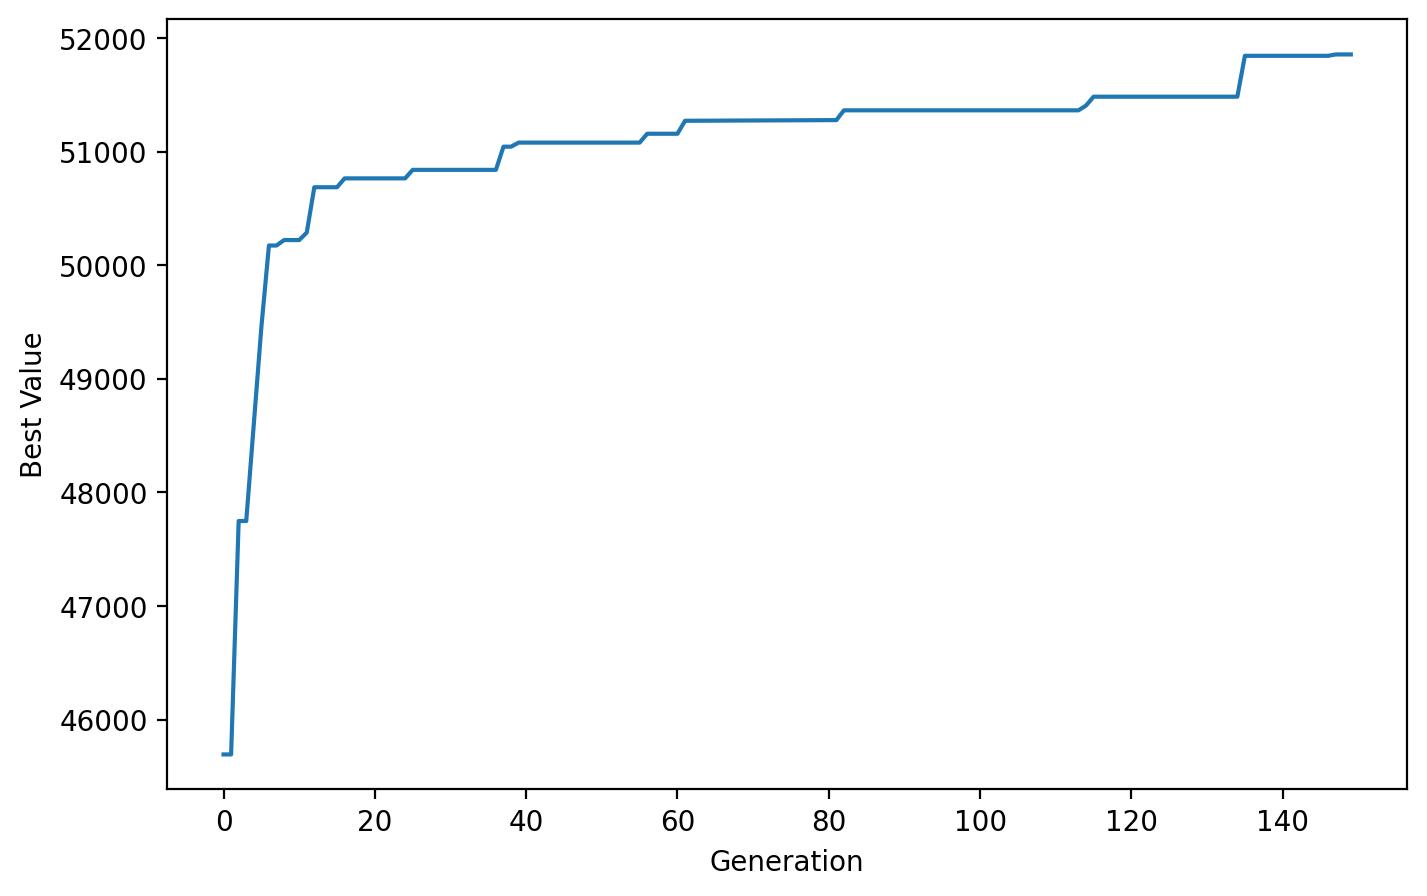

In [ ]:
from IPython.display import clear_output


def ga(population):
    best = the_best(population)
    generations_not_improved = 0
    generation = 1
    best_values = [fit(best)]
    # Iterar hasta que no se mejore en 10 generaciones o se alcance la generación 100
    while generations_not_improved < 50 and generation < 150:
        print(f"-> Generation {generation} best value: {best['fitness'][2]}")
        population = select_with_crossover(population)
        elite = max(population, key=lambda i: i['fitness'][2])

        mutation(population, 0.01 + (generations_not_improved/100),
                 0.01 + (generations_not_improved/200))
        new_best = max(population, key=lambda i: i['fitness'][2])
        # Si en la mutación se perdió el individuo de la elite, reemplazar el peor de la población
        if new_best['fitness'][2] < elite['fitness'][2]:
            min_item = min(population, key=lambda i: i['fitness'][2])
            population[population.index(min_item)] = elite
            new_best = elite

        # Si se mejoró el mejor individuo, actualizar y resetear el contador
        if new_best['fitness'][2] > best['fitness'][2]:
            best = new_best
            generations_not_improved = 0
        else:
            generations_not_improved += 1
        best_values.append(fit(best))
        generation += 1
        # Dibujar un gráfico con la evolución de los valores
        clear_output(wait=True)
        plt.plot(best_values)
        plt.ylabel('Best Value')
        plt.xlabel('Generation')
        plt.show()
    return population


population = ga(population)

In [ ]:
population

[{'types_num': [1, 2, 13, 9, 6, 12, 3, 5, 4, 8, 10, 0, 7, 11],
  'counts': [70, 28, 43, 25, 110, 81, 17, 121, 108, 25, 36, 156, 44, 0],
  'rotations': [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0],
  'fitness': [0.82, 864, 51843],
  'result': [[0, 0, 0, 3, 4, 3, 1],
   [0, 4, 0, 3, 4, 3, 1],
   [0, 8, 0, 3, 4, 3, 1],
   [0, 12, 0, 3, 4, 3, 1],
   [0, 16, 0, 3, 4, 3, 1],
   [0, 0, 3, 3, 4, 3, 1],
   [0, 4, 3, 3, 4, 3, 1],
   [0, 8, 3, 3, 4, 3, 1],
   [0, 12, 3, 3, 4, 3, 1],
   [0, 16, 3, 3, 4, 3, 1],
   [0, 0, 6, 3, 4, 3, 1],
   [0, 4, 6, 3, 4, 3, 1],
   [0, 8, 6, 3, 4, 3, 1],
   [0, 12, 6, 3, 4, 3, 1],
   [0, 16, 6, 3, 4, 3, 1],
   [0, 0, 9, 3, 4, 3, 1],
   [0, 4, 9, 3, 4, 3, 1],
   [0, 8, 9, 3, 4, 3, 1],
   [0, 12, 9, 3, 4, 3, 1],
   [0, 16, 9, 3, 4, 3, 1],
   [0, 0, 12, 3, 4, 3, 1],
   [0, 4, 12, 3, 4, 3, 1],
   [0, 8, 12, 3, 4, 3, 1],
   [0, 12, 12, 3, 4, 3, 1],
   [0, 16, 12, 3, 4, 3, 1],
   [0, 0, 15, 3, 4, 3, 1],
   [0, 4, 15, 3, 4, 3, 1],
   [0, 8, 15, 3, 4, 3, 1],
   [0, 12, 15, 3

In [ ]:
fit(max_rand), the_best_fit(population)

(45693, 51855)

In [ ]:
"Mejora en %.1f%%" % (100*the_best_fit(population) / fit(max_rand) - 100)

'Mejora en 13.5%'

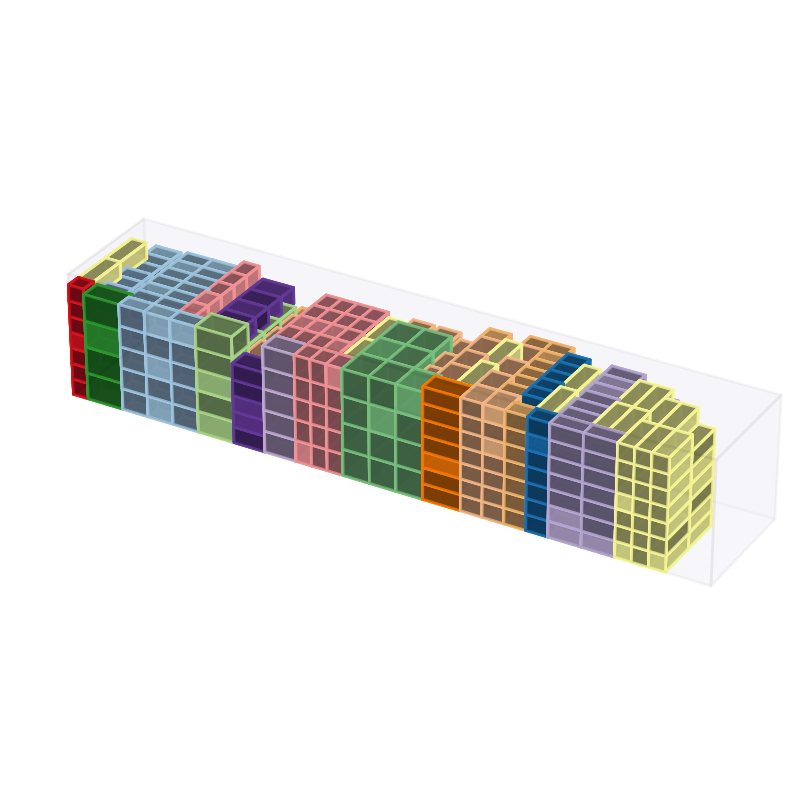

In [ ]:
draw_anim_types(max_rand)

In [ ]:
the_best(population)

{'types_num': [1, 2, 13, 9, 6, 3, 12, 5, 4, 8, 10, 0, 7, 11],
 'counts': [70, 28, 43, 25, 110, 17, 84, 121, 108, 25, 36, 156, 42, 0],
 'rotations': [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
 'fitness': [0.82, 865, 51855],
 'result': [[0, 0, 0, 3, 4, 3, 1],
  [0, 4, 0, 3, 4, 3, 1],
  [0, 8, 0, 3, 4, 3, 1],
  [0, 12, 0, 3, 4, 3, 1],
  [0, 16, 0, 3, 4, 3, 1],
  [0, 0, 3, 3, 4, 3, 1],
  [0, 4, 3, 3, 4, 3, 1],
  [0, 8, 3, 3, 4, 3, 1],
  [0, 12, 3, 3, 4, 3, 1],
  [0, 16, 3, 3, 4, 3, 1],
  [0, 0, 6, 3, 4, 3, 1],
  [0, 4, 6, 3, 4, 3, 1],
  [0, 8, 6, 3, 4, 3, 1],
  [0, 12, 6, 3, 4, 3, 1],
  [0, 16, 6, 3, 4, 3, 1],
  [0, 0, 9, 3, 4, 3, 1],
  [0, 4, 9, 3, 4, 3, 1],
  [0, 8, 9, 3, 4, 3, 1],
  [0, 12, 9, 3, 4, 3, 1],
  [0, 16, 9, 3, 4, 3, 1],
  [0, 0, 12, 3, 4, 3, 1],
  [0, 4, 12, 3, 4, 3, 1],
  [0, 8, 12, 3, 4, 3, 1],
  [0, 12, 12, 3, 4, 3, 1],
  [0, 16, 12, 3, 4, 3, 1],
  [0, 0, 15, 3, 4, 3, 1],
  [0, 4, 15, 3, 4, 3, 1],
  [0, 8, 15, 3, 4, 3, 1],
  [0, 12, 15, 3, 4, 3, 1],
  [0, 16, 15, 3, 4, 3

In [ ]:
types

[{'container': [66, 0, 0, 15, 23, 23, 0],
  'value_individual': 60,
  'box_size': [5, 3, 4],
  'volume_individual': 60,
  'volume_total': 6300,
  'value_total': 6300,
  'boxes_count': 105,
  'max_count': 156},
 {'container': [95, 0, 0, 25, 7, 23, 1],
  'value_individual': 36,
  'box_size': [4, 3, 3],
  'volume_individual': 36,
  'volume_total': 2592,
  'value_total': 2592,
  'boxes_count': 72,
  'max_count': 102},
 {'container': [88, 0, 0, 7, 23, 23, 2],
  'value_individual': 140,
  'box_size': [7, 5, 4],
  'volume_individual': 140,
  'volume_total': 2800,
  'value_total': 2800,
  'boxes_count': 20,
  'max_count': 28},
 {'container': [81, 0, 0, 7, 23, 23, 3],
  'value_individual': 140,
  'box_size': [7, 4, 5],
  'volume_individual': 140,
  'volume_total': 2800,
  'value_total': 2800,
  'boxes_count': 20,
  'max_count': 29},
 {'container': [18, 0, 0, 32, 11, 23, 4],
  'value_individual': 48,
  'box_size': [4, 3, 4],
  'volume_individual': 48,
  'volume_total': 5040,
  'value_total': 504

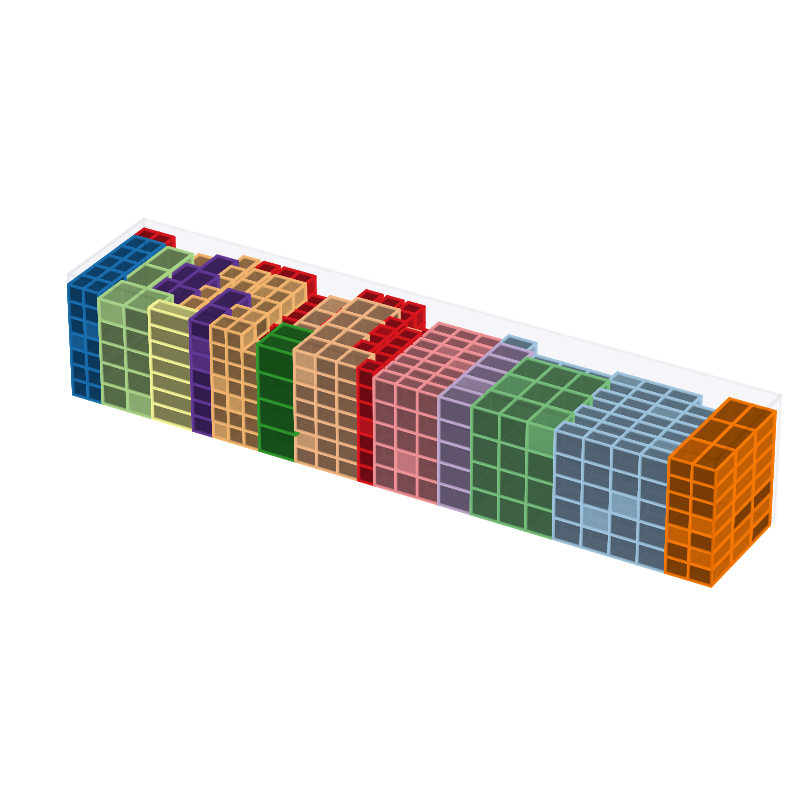

In [ ]:
draw_anim_types(the_best(population))

In [ ]:
best = the_best(population)
sns.color_palette([pallete[best['types_num'][i]] for i in range(len(best['types_num'])) if best['counts'][i] > 0 ])

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (1.0, 1.0, 0.6),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (1.0, 0.4980392156862745, 0.0)]

In [ ]:
print(best['types_num'])
print(best['counts'])

[1, 2, 13, 9, 6, 3, 12, 5, 4, 8, 10, 0, 7, 11]
[70, 28, 43, 25, 110, 17, 84, 121, 108, 25, 36, 156, 42, 0]


In [ ]:
types[13]

{'container': [95, 7, 0, 25, 8, 23, 13],
 'value_individual': 72,
 'box_size': [3, 8, 3],
 'volume_individual': 72,
 'volume_total': 3024,
 'value_total': 3024,
 'boxes_count': 42,
 'max_count': 61}